# calculate the eigenvalue of Ising transfer matrix using HOTRG
Goal: consider a 2d square lattice Ising model with length LxW, try to calculate the partition function at temperature T. <br>
As talked in [this paper](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.81.174411) , we can map this original question to a tensor contraction problem <left><img src="demo.png" alt="drawing" width="400"/></left>
Since the final answer is a scalar, which should not be affected by tensor contraction order. One can try to merge the column into a single matrix, and multiply the tensor to get the final partition function. Or we can also use [higher order tensor renormalization group](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.86.045139) algorithm to solve this problem. <br>

For the method 1, since we have contracted all the tensors on 1 dimension, the problem reduce to a 1d partition problem, which can be solved by transfer matrix method. Besides, we can also use these eigenvalue to calculate correlation length. 
<center>$\xi = 1/\log(\lambda_1/\lambda_2)$</center> $\lambda_1$ and $\lambda_2$ represent the largest and second eigenvalue in transfer matrix $T$
<left><img src="way1.png" alt="drawing" width="600"/></left>

On the other hand, we can also use the HOTRG algorithm to contract these tensors, notice for the HOTRG we are actually dealing the system with size LxL, if we contract the whole tensor and calculate the eigenvalue $\widetilde{\lambda}$,
to compare with eigenvalues got from method1. we would find
<center>$\widetilde{\lambda}_i^{(L,L)}  \approx (\lambda_i^{(1,L)})^{L}$ </center> 
or we can define 
<center>$\widetilde{\lambda}_i^{(1,L)} \equiv (\widetilde{\lambda}_i^{(L,L)})^{1/L}$ </center>,here
$\approx$ because we may do the truncation when applying isometry tensor.
<left><img src="way2.png" alt="drawing" width="600"/></left>

In addition, when we applying HOTRG, we  need to handle the normalization factor $N_L$. For the tensor may diverge after several times of RG. 
<left><img src="way2_1.png" alt="drawing" width="600"/></left>

In this note, we will deal with transfer matrix using HOTRG. In other words, we want to calculate $\widetilde{\lambda}^{(L,L)}$ and compare the value between $\lambda^{(1,L)}$ and $\widetilde{\lambda}^{(1,L)}$

In [3]:
import numpy as np
from math import pi
from scipy import linalg
import time, itertools
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import os
import glob
import re

st_digit = '\d?'*16
def getL(name):
    L = re.findall(r"L=({})".format(st_digit),name)[-1]
    return int(L)

In [this book](https://www.worldscientific.com/doi/abs/10.1142/9789812774811_0006) , there is a exact way to calculate the first two eigenvalue of transfer matrix ($\lambda_1 $ and $\lambda_2$) . I have put the data on dropbox

In [4]:
exact_lambda_Tc = pd.read_csv('./exact/exact_soln_Tc.csv')
print(exact_lambda_Tc)

   Unnamed: 0  ln(Lambda_even)  ln(Lambda_odd)
0         L=2         2.010105        1.574521
1         L=4         3.787137        3.584626
2         L=8         7.470597        7.371762
3        L=16        14.891526       14.842359
4        L=32        29.758439       29.733885
5        L=64        59.504597       59.492324
6       L=128       119.003056      118.996920
7       L=256       238.003045      237.999977
8       L=512       476.004555      476.003021
9      L=1024       952.008344      952.007577
10     L=2048      1904.016304     1904.015920
11     L=4096      3808.032416     3808.032224
12     L=8192      7616.064735     7616.064639
13    L=16384     15232.129420    15232.129370
14    L=32768     30464.258820    30464.258800
15    L=65536     60928.517630    60928.517620
16   L=131072    121857.035300   121857.035200
17   L=262144    243714.070500   243714.070500
18   L=524288    487428.141000   487428.141000


from [this paper](https://arxiv.org/abs/1204.3934) we can calculate the ground state energy $E_0$ and try to fit in our result
- First, from theoretical result, $E_0(N) -E_0(\infty) =  \pi c / (6N^2) $ , fitting to get $E_0(\infty)$ , here we want to consider energy per site. 
- Second, try to approach to two limit: FSS and FES with our result
- FSS: $E_0(N) -E_0(\infty) = -\pi c / (6N^2) $
- FES: $E_0(D) -E_0(\infty) \approx \Delta / D^\omega  = \Delta / D^{2 \kappa } $

0.9296953983416102
value: [0.2689201  0.01082696]
error: [0.00052856 0.00018171]


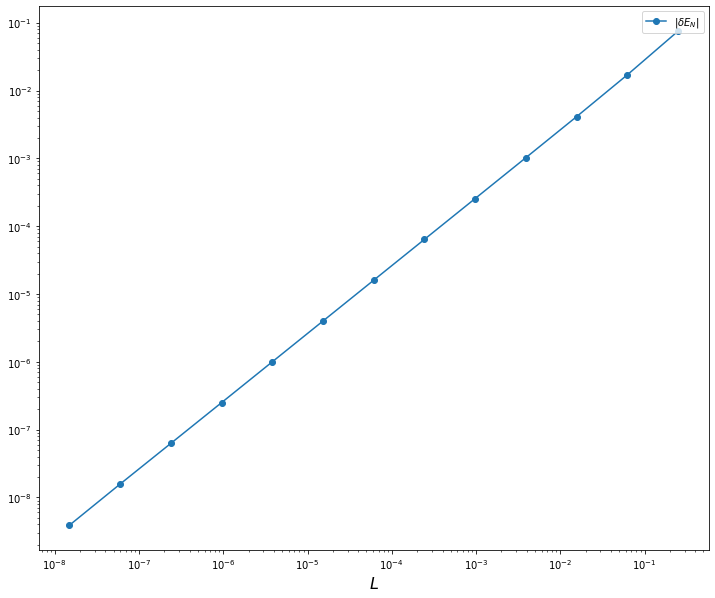

In [3]:
# calculate theoretical E_0 for N -> infinity
exact_lambda_Tc['L'] = [2**i for i in range(1,20)]
exact_lambda_Tc['E_0(N)'] = exact_lambda_Tc['ln(Lambda_even)'] / exact_lambda_Tc['L']

E_0 = 0.929695398341610214985

from scipy.optimize import curve_fit

def fitting_EN(x,a,b):
    ''' after subtract E_0, E(N) = b/N**2'''
    return  a/(x**2)+b/(x**2)/(np.log(L)**3)

L = exact_lambda_Tc['L'].values[:-6]

E_N = np.abs(exact_lambda_Tc['E_0(N)'].values - E_0)[:-6]

popc,pcov = curve_fit(fitting_EN,L,E_N)
LsquareCoef,_ = popc
print(E_0)
print('value:',popc)
print('error:',np.sqrt(np.diag(pcov)))
plt.figure(figsize=(12,10))
plt.plot(1/L**2,E_N,'o-',label='$|\delta E_{N}|$')
# plt.plot(L,fitting_EN(L,*popc),label="y=${:.4}\\times(1/L^2)+{:.3}\\times(1/L^2) \\times (1/ (\log (L))^3)\
#          $".format(*popc))
plt.xscale('log')
plt.xlabel('$L$',fontsize=16)
plt.legend(loc=1)
plt.yscale('log')
# plt.savefig('fitting exact E_N.pdf')

In [4]:
def put_normalization_back_divL(log_lambda_primes,Normalizations): 
    '''put the normalization back to lambda' to get $\widetilde{\lambda}$ '''
    result = []
    lastN = np.log(Normalizations[0]) # which should be 0
    total_RG_steps = len(log_lambda_primes)
    for i,lambda_i in enumerate(log_lambda_primes): #all take log
        result.append(lambda_i/2**i+lastN)
        lastN = 2*lastN + np.log(Normalizations[i+1])
    return result


def put_normalization_back(log_lambda_primes,Normalizations): 
    '''put the normalization back to lambda' to get $\widetilde{\lambda}$ '''
    result = []
    lastN = np.log(Normalizations[0]) # which should be 0
    total_RG_steps = len(log_lambda_primes)
    for i,lambda_i in enumerate(log_lambda_primes): #all take log
#         result.append(lambda_i+lastN)
        result.append(lambda_i+lastN)
        lastN = 4*lastN + np.log(Normalizations[i+1])
    return result

FILE = './raw data (with Normalization Factor)/'
bds = [24,28,30,32,36,40,50,60]
bds = list(map(str,bds))

log_lambda_primes = glob.glob(FILE+"*Tc*D*.csv") # I have dealed with the power of L in lambda' and take log at first
Normalizations = glob.glob(r'./transfer_matrix_rescale_factor/*Tc*D*.csv')

for bd in bds:
    DF = {}
    for log_lambda_prime in log_lambda_primes:
        if 'D'+bd+'.csv' in log_lambda_prime:
            log_lambda_prime_bd = log_lambda_prime
    for Normalization in Normalizations:
        if 'D'+bd + '.csv' in Normalization:
            Normalization_bd = Normalization
    log_lambda_prime_bd_csv   = pd.read_csv(log_lambda_prime_bd)
    Normalization_bd_csv = pd.read_csv(Normalization_bd)
    normalized = Normalization_bd_csv['T=Tc'].values
    log_lambda_prime_bd_even   = log_lambda_prime_bd_csv.iloc[0,1:]
    log_lambda_prime_bd_odd    = log_lambda_prime_bd_csv.iloc[1,1:]
    Ls = Normalization_bd_csv.iloc[:-1,0]
    DF['ln(Lambda_wave_even)'] = put_normalization_back(log_lambda_prime_bd_even,normalized)
    DF['ln(Lambda_wave_odd)']  = put_normalization_back(log_lambda_prime_bd_odd,normalized)
    DataFrame = pd.DataFrame(DF)
    DataFrame.index = Ls
    DataFrame.to_csv(FILE+'ln_lambda_wave_D{}.csv'.format(bd))

<ipython-input-27-a910905d8c3e>:10: RuntimeWarning: divide by zero encountered in true_divide
  correlation_length_divL = 1/((log_lambda_prime_even - log_lambda_prime_odd))
<ipython-input-27-a910905d8c3e>:12: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot((1/Ls**2)[1:],correlation_length_divL[1:],'o-',label='Dcut={}'.format(bd))


[  1.13459266   1.1478834    1.23450255   1.26474447   1.27118337
   1.27274644   1.27324566   1.27366061   1.27429944   1.27539782
   1.2770694    1.27920781   1.28165151   1.28457396   1.28912534
   1.29855799   1.32130031   1.37290577   1.49630695   1.81580406
   2.82482759   9.0619469  128.                  inf          inf
   8.           2.                  inf          inf          inf
          inf          inf          inf          inf          inf
          inf          inf          inf          inf          inf
          inf          inf          inf          inf          inf
          inf          inf          inf          inf          inf]


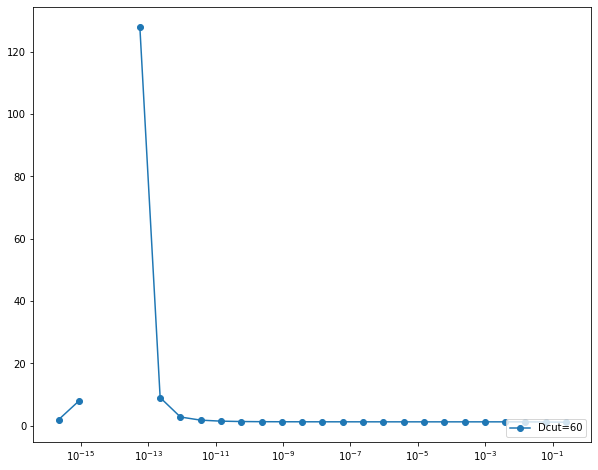

In [27]:
# experiment  1 : to see the crossing point
plt.figure(figsize=(10,8))
bds = [60]

for bd in bds:
    ln_lambda_wave = pd.read_csv(FILE+'ln_lambda_wave_D{}.csv'.format(bd))
    Ls = np.array(list(map(getL,ln_lambda_wave['Dcut={}'.format(bd)])))
    log_lambda_prime_even = ln_lambda_wave['ln(Lambda_wave_even)'].values 
    log_lambda_prime_odd  = ln_lambda_wave['ln(Lambda_wave_odd)'].values 
    correlation_length_divL = 1/((log_lambda_prime_even - log_lambda_prime_odd))  
    print(correlation_length_divL)
    plt.plot((1/Ls**2)[1:],correlation_length_divL[1:],'o-',label='Dcut={}'.format(bd))


plt.legend(loc=4)
plt.xscale('log')
# plt.xlim((10**-13,10**-3))
# plt.ylim((0,2))
# plt.yscale('log')/

### compare the result with exact $\lambda_1$ and $\lambda_2$

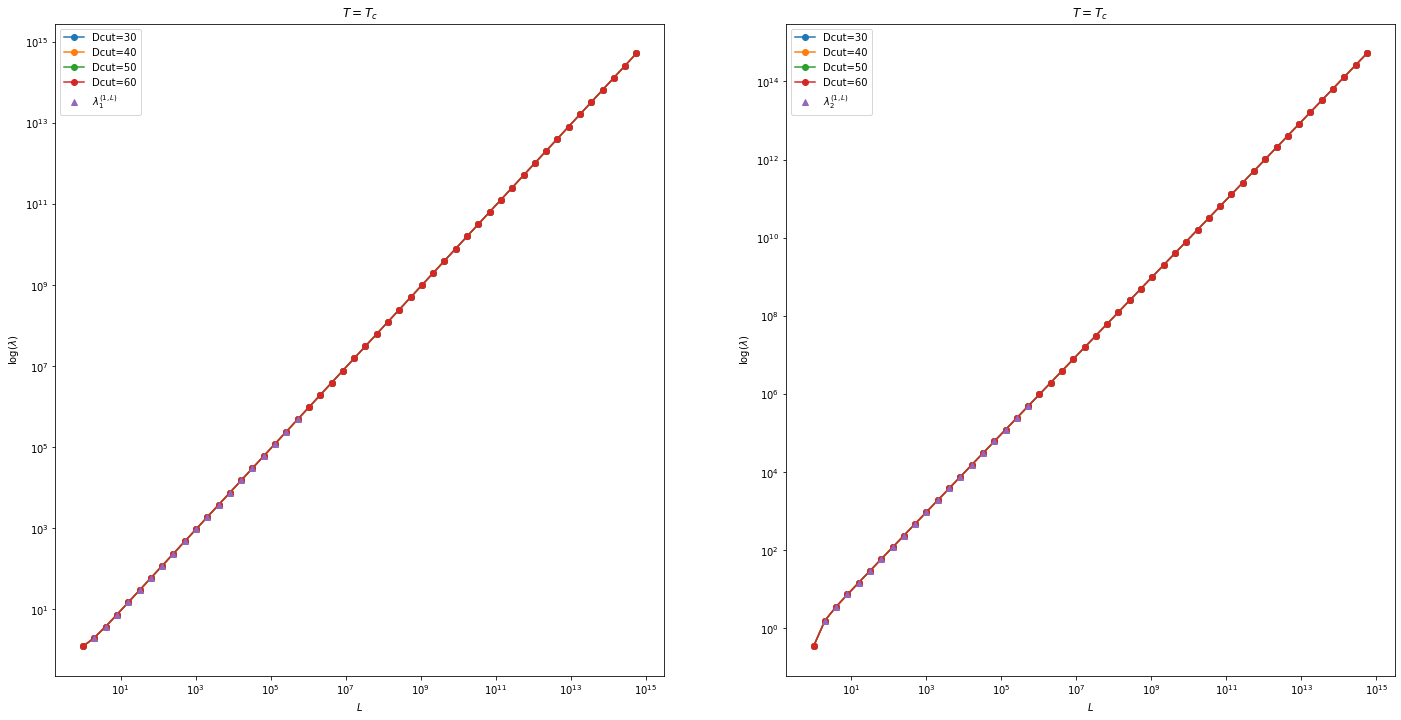

In [15]:


plt.figure(figsize=(24,12))
bds = [30,40,50,60]
plt.subplot(1,2,1)
for bd in bds:
    ln_lambda_wave = pd.read_csv(FILE+'ln_lambda_wave_D{}.csv'.format(bd))
    
    Ls = np.array(list(map(getL,ln_lambda_wave['Dcut={}'.format(bd)])))
    log_Lambda_prime_even = ln_lambda_wave['ln(Lambda_wave_even)'].values/Ls
    plt.plot(Ls,log_Lambda_prime_even,'o-',label='Dcut={}'.format(bd))
Ls  = list(map(getL,exact_lambda_Tc.iloc[:,0]))
exact_even = exact_lambda_Tc['ln(Lambda_even)'].values
plt.plot(Ls,exact_even,'^',label='$\lambda^{(1,L)}_1$')
plt.xscale('log')
plt.xlabel('$L$')
plt.yscale('log')
plt.ylabel('$\log(\lambda)$')
plt.legend(loc='best')
plt.title('$T=T_c$')
plt.subplot(1,2,2)
for bd in bds:
    ln_lambda_wave = pd.read_csv(FILE+'ln_lambda_wave_D{}.csv'.format(bd))
    
    Ls = np.array(list(map(getL,ln_lambda_wave['Dcut={}'.format(bd)])))
    log_Lambda_prime_even = ln_lambda_wave['ln(Lambda_wave_odd)'].values/Ls
    plt.plot(Ls,log_Lambda_prime_even,'o-',label='Dcut={}'.format(bd))

Ls  = list(map(getL,exact_lambda_Tc.iloc[:,0]))
exact_odd = exact_lambda_Tc['ln(Lambda_odd)'].values
plt.plot(Ls,exact_odd,'^',label='$\lambda^{(1,L)}_2$')
plt.xscale('log')
plt.xlabel('$L$')
plt.yscale('log')
plt.ylabel('$\log(\lambda)$')
plt.title('$T=T_c$')
plt.legend(loc='best')
# plt.savefig('Transfer_matrix_eigenvalue.pdf')

<ipython-input-19-d06576cd0b4d>:24: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/Ls**2,minus_result,'o-',label='Dcut={}'.format(bd),markersize=10,fillstyle='none')
<ipython-input-19-d06576cd0b4d>:24: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/Ls**2,minus_result,'o-',label='Dcut={}'.format(bd),markersize=10,fillstyle='none')
<ipython-input-19-d06576cd0b4d>:24: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/Ls**2,minus_result,'o-',label='Dcut={}'.format(bd),markersize=10,fillstyle='none')
<ipython-input-19-d06576cd0b4d>:24: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/Ls**2,minus_result,'o-',label='Dcut={}'.format(bd),markersize=10,fillstyle='none')
<ipython-input-19-d06576cd0b4d>:24: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/Ls**2,minus_result,'o-',label='Dcut={}'.format(bd),markersize=10,fillstyle='none')


Text(0.5, 1.0, '$T=T_c$')

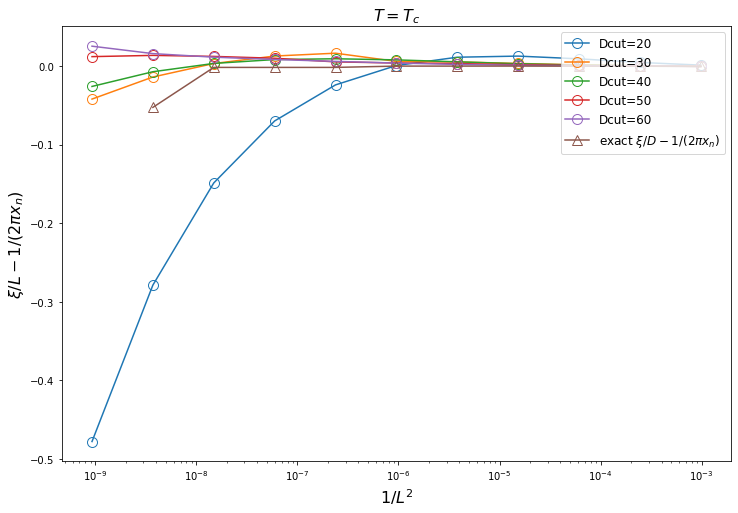

In [19]:
def getL(name):
    L = re.findall(r"L=(\d?\d?\d?\d?\d?\d?\d?\d?\d?)",name)[-1]
    return int(L)

plt.figure(figsize=(12,8))
bds = [20]

# bds = [4,8]
bds_2 = [x for x in range(2,20) if x not in bds]
bds = [20,30,40,50,60]

delta_E_D = []
for bd in bds:
    ln_lambda_wave = pd.read_csv(FILE+'ln_lambda_wave_D{}.csv'.format(bd))
    
    Ls = np.array(list(map(getL,ln_lambda_wave['Dcut={}'.format(bd)])))[5:17]
    Ls2 = Ls**2
    log_Lambda_prime_even = ln_lambda_wave['ln(Lambda_wave_even)'].values[5:17]
    log_Lambda_prime_odd = ln_lambda_wave['ln(Lambda_wave_odd)'].values[5:17]
    E_N = log_Lambda_prime_even 
    E_N_1 = log_Lambda_prime_odd 

    minus_result = 1/((np.abs(E_N_1  - E_N)))  - (8/(2*np.pi))
    plt.plot(1/Ls**2,minus_result,'o-',label='Dcut={}'.format(bd),markersize=10,fillstyle='none')
#     plt.plot(Ls,delta_E_N,'o-',label='Dcut={}'.format(bd),markersize=10,fillstyle='none')
#     plt.plot(Ls,delta_E_NxL,'o-',label='$E_0 Dcut={}$'.format(bd),markersize=10,fillstyle='none')
#     plt.plot(Ls,delta_E_N_1xL,'o-',label='$E_1 Dcut={}$'.format(bd),markersize=10,fillstyle='none')

Ls_exact  = np.array(list(map(getL,exact_lambda_Tc.iloc[:,0])))[4:14]
Ls_exact_square = Ls_exact **2 
exact_even = exact_lambda_Tc['ln(Lambda_even)'].values[4:14]
exact_odd = exact_lambda_Tc['ln(Lambda_odd)'].values[4:14]
minus_result = 1/((np.abs(exact_even  - exact_odd))*Ls_exact)  - (8/(2*np.pi))
plt.plot(1/Ls_exact_square,minus_result,'^-',label=r'exact $ \xi / D - 1/(2 \pi x_n)$',markersize=10,fillstyle='none')
plt.xscale('log')
plt.xlabel('$1/L^2$',fontsize=16)

plt.ylabel(r'$\xi /L - 1/(2\pi x_n)$',fontsize=16)
plt.legend(loc=1,fontsize=12)
plt.title('$T=T_c$',fontsize=16)
# plt.savefig('xi over L vs Lsquare(abnormal)_2.pdf')

<ipython-input-23-633df9edaaca>:12: RuntimeWarning: divide by zero encountered in true_divide
  E_N = log_Lambda_prime_even / Ls**2
<ipython-input-23-633df9edaaca>:12: RuntimeWarning: divide by zero encountered in true_divide
  E_N = log_Lambda_prime_even / Ls**2
<ipython-input-23-633df9edaaca>:12: RuntimeWarning: divide by zero encountered in true_divide
  E_N = log_Lambda_prime_even / Ls**2


Text(0.5, 1.0, '$T=T_c$')

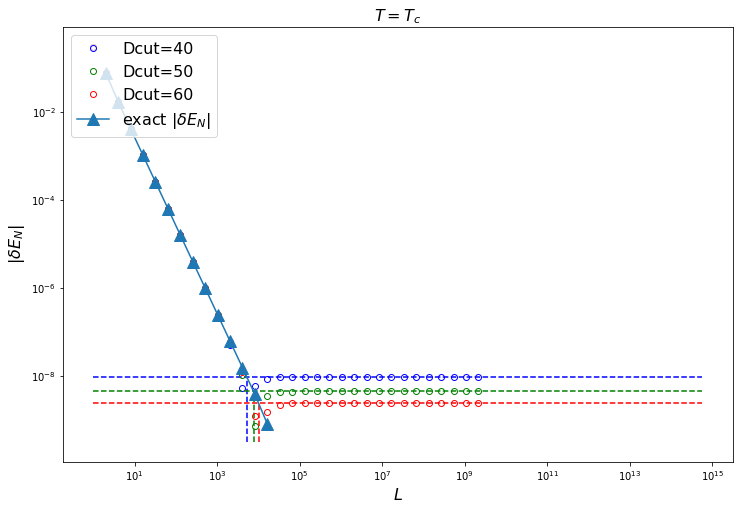

In [23]:


plt.figure(figsize=(12,8))
bds = [40,50,60]
colors = 'bgrcmyk'
delta_E_D = []
lengthFromE_D = []
for bd,color in zip(bds,colors):
    ln_lambda_wave = pd.read_csv(FILE+'ln_lambda_wave_D{}.csv'.format(bd))
    
    Ls = np.array(list(map(getL,ln_lambda_wave['Dcut={}'.format(bd)])))
    log_Lambda_prime_even = ln_lambda_wave['ln(Lambda_wave_even)'].values
    log_Lambda_prime_odd = ln_lambda_wave['ln(Lambda_wave_odd)'].values
    E_N = log_Lambda_prime_even / Ls**2
    delta_E_N = np.abs(E_N - E_0)
    y = delta_E_N[18]
    delta_E_D.append(y)
    lengthFromE_D.append((y/LsquareCoef)**(-1/2))
    plt.plot(Ls,delta_E_N,color+'o',label='Dcut={}'.format(bd),markersize=6,fillstyle='none')
    plt.plot(Ls,[delta_E_N[18] for i in range(len(Ls))],color+'--')
    plt.plot([(y/LsquareCoef)**(-1/2) for i in range(100)],np.linspace(10**-9.5,y,100),color+'--')
Ls  = list(map(getL,exact_lambda_Tc.iloc[:,0]))[:-5]
plt.plot(Ls,exact_lambda_Tc['E_0(N)'][:-5]-E_0,'^-',label='exact $ |\delta E_N |$',markersize=12)
# plt.ylim((10**-9.5,10**-2))
# plt.xlim((1,2**19.5))
plt.xscale('log')
plt.xlabel('$L$',fontsize=16)
plt.yscale('log')
plt.ylabel('$|\delta E_N|$',fontsize=16)
plt.legend(loc=2,fontsize=16)
plt.title('$T=T_c$',fontsize=16)
# plt.savefig('Get Length.pdf')

value: [10.64701222  1.68187932]
error: [1.68881169 0.03981388]


Text(0.5, 1.0, '$T=T_c$')

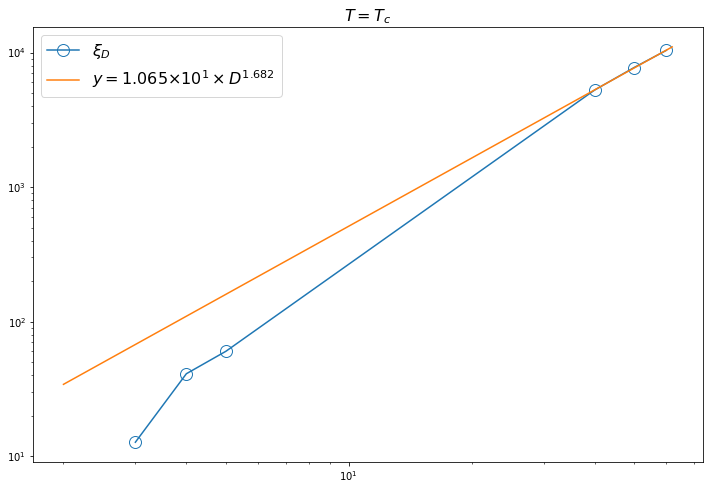

In [63]:
def getL(name):
    L = re.findall(r"L=(\d?\d?\d?\d?\d?\d?\d?\d?\d?)",name)[-1]
    return int(L)

plt.figure(figsize=(12,8))
one_over_bds = 1/np.array(bds)
bds = np.array(bds)
lengthFromE_D = np.array(lengthFromE_D).ravel()
plt.plot(bds,lengthFromE_D,'o-',label=r'$\xi_D$',markersize=12,fillstyle='none')
def fitting_D(x,b,c):
    return  b*(x**c)

popc,pcov = curve_fit(fitting_D,bds[1:],lengthFromE_D[1:])
b,c = popc
import matplotlib.ticker as mticker
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "{}".format(f._formatSciNotation('{:.3e}'.format(x)))
fmt = mticker.FuncFormatter(g)

print('value:',popc)
print('error:',np.sqrt(np.diag(pcov)))
Xs = np.linspace(2,62,100)

plt.plot(Xs,fitting_D(Xs,*popc),label=r"$y={} \times D{}$".format(fmt(b),'^{'+fmt(c)+'}'))
plt.ticklabel_format(axis="x", style="sci")


# plt.xlim((0.5,1200))

# plt.xlabel('$log_{10}(D)$',fontsize=16)

# plt.ylabel('$\log_{10} (|\delta E_D|)$',fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best',fontsize=16)
plt.title('$T=T_c$',fontsize=16)
# plt.savefig('fitting Length(D).pdf')

<ipython-input-55-b3f836c4f046>:24: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/Ls**2,delta_E_N,'o-',label='Dcut={}'.format(bd),markersize=10,fillstyle='none')
<ipython-input-55-b3f836c4f046>:24: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/Ls**2,delta_E_N,'o-',label='Dcut={}'.format(bd),markersize=10,fillstyle='none')
<ipython-input-55-b3f836c4f046>:24: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/Ls**2,delta_E_N,'o-',label='Dcut={}'.format(bd),markersize=10,fillstyle='none')
<ipython-input-55-b3f836c4f046>:24: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/Ls**2,delta_E_N,'o-',label='Dcut={}'.format(bd),markersize=10,fillstyle='none')


Text(0.5, 1.0, '$T=T_c$')

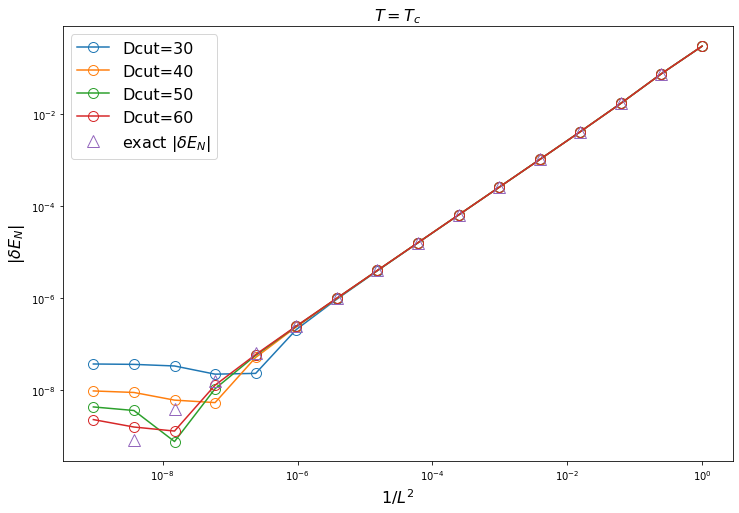

In [55]:
def getL(name):
    L = re.findall(r"L=(\d?\d?\d?\d?\d?\d?\d?\d?\d?)",name)[-1]
    return int(L)

plt.figure(figsize=(12,8))
bds = [30,40,50,60]

delta_E_D = []
for bd in bds:
    ln_lambda_wave = pd.read_csv('ln_lambda_wave_D{}.csv'.format(bd))
    
    Ls = np.array(list(map(getL,ln_lambda_wave['Dcut={}'.format(bd)])))
    log_Lambda_prime_even = ln_lambda_wave['ln(Lambda_wave_even)'].values
    log_Lambda_prime_odd = ln_lambda_wave['ln(Lambda_wave_odd)'].values
    E_N = log_Lambda_prime_even / Ls
    E_N_1 = log_Lambda_prime_odd / Ls
    delta_E_N = np.abs(E_N - E_0)
#     delta_E_N_1 = np.abs(E_N_1)
#     delta_E_NxL = delta_E_N * Ls
#     delta_E_N_1xL = delta_E_N_1 * Ls
#     minus_result = np.abs(delta_E_N_1xL  - delta_E_NxL)*Ls/(2*np.pi)
    delta_E_D.append(delta_E_N[19])
#     plt.plot(Ls,minus_result,'o-',label='Dcut={}'.format(bd),markersize=10,fillstyle='none')
    plt.plot(1/Ls**2,delta_E_N,'o-',label='Dcut={}'.format(bd),markersize=10,fillstyle='none')
#     plt.plot(Ls,delta_E_NxL,'o-',label='$E_0 Dcut={}$'.format(bd),markersize=10,fillstyle='none')
#     plt.plot(Ls,delta_E_N_1xL,'o-',label='$E_1 Dcut={}$'.format(bd),markersize=10,fillstyle='none')
Ls  = np.array(list(map(getL,exact_lambda_Tc.iloc[:,0]))[:-5])
plt.plot(1/Ls**2,exact_lambda_Tc['E_0(N)'][:-5]-E_0,'^',label='exact $ |\delta E_N |$',markersize=12,fillstyle='none')
# plt.ylim((10**-9.5,10**0))
# plt.xlim((1,2**19.5))
plt.xscale('log')
plt.xlabel('$1/L^2$',fontsize=16)
plt.yscale('log')
plt.ylabel('$|\delta E_N|$',fontsize=16)
# plt.ylabel(r'$L \times (|\delta E^1_N| - |\delta E^0_N|)$',fontsize=16)
plt.legend(loc=2,fontsize=16)
plt.title('$T=T_c$',fontsize=16)
# plt.savefig('delta E_N versus system size N.pdf')

value: [1.59866211e-09 1.05178674e+00 5.06000212e+00]
error: [3.92859843e-10 7.68369698e-01 2.17172887e-01]


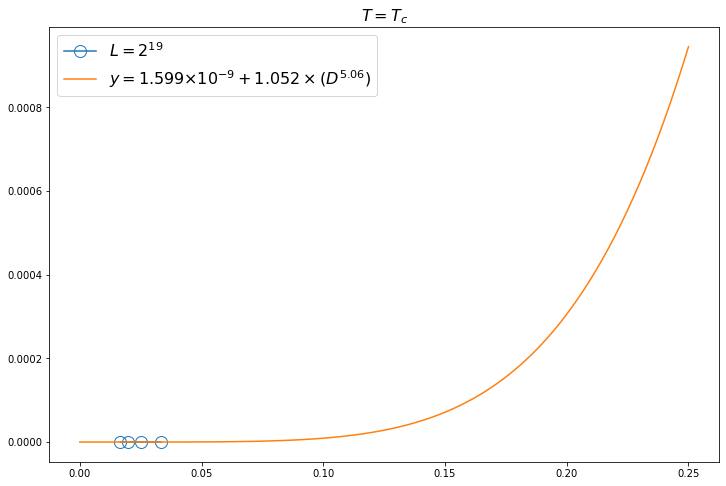

In [56]:
def getL(name):
    L = re.findall(r"L=(\d?\d?\d?\d?\d?\d?\d?\d?\d?)",name)[-1]
    return int(L)

plt.figure(figsize=(12,8))
one_over_bds = 1/np.array(bds)

delta_E_D = np.array(delta_E_D)
plt.plot(one_over_bds,delta_E_D,'o-',label='$L=2^{19}$',markersize=12,fillstyle='none')
def fitting_D(x,a,b,c):
    return a + b*(x**c)


popc,pcov = curve_fit(fitting_D,one_over_bds,delta_E_D)
a,b,c = popc
import matplotlib.ticker as mticker
f = mticker.ScalarFormatter(useOffset=False, useMathText=True)
g = lambda x,pos : "{}".format(f._formatSciNotation('{:.3e}'.format(x)))
fmt = mticker.FuncFormatter(g)

print('value:',popc)
print('error:',np.sqrt(np.diag(pcov)))
Xs = np.linspace(0,0.25,100)

plt.plot(Xs,fitting_D(Xs,*popc),label=r"$y={}+{} \times (D{})$".format(fmt(a),fmt(b),'^{'+fmt(c)+'}'))
plt.ticklabel_format(axis="x", style="sci")
# plt.xlim((0.5,1200))

# plt.xlabel('$log_{10}(D)$',fontsize=16)

# plt.ylabel('$\log_{10} (|\delta E_D|)$',fontsize=16)
plt.legend(loc='best',fontsize=16)
plt.title('$T=T_c$',fontsize=16)
plt.savefig('fitting_finiteD.pdf')

From the result, we see our result is consistent with exact solution even though our bond dimension is not quite large. ( even for small bond dimension like $d_{cut}=4$ still quite good. 

# check other eigenvalues

Consider transfer matrix of a stripe of length L with periodic boundary condition. The transfer matrix can be described as $\exp(-\hat{H})$. According to [this paper](https://www.sciencedirect.com/science/article/pii/B9780444871091500388), the eigenvalue $E_n$ of $\hat{H}$  and scaling dimension $x_n$ has the following relation.
<center>$E_n - E_0 \approx 2\pi x_n / L$ </center>

Let's check these relation with our data

In [16]:
def makeFolder(Filename,sep='/'):
    '''file name may contains several folders, so need to check
    individually'''
    subFolderPath = Filename.split('/')
    complete = '.'
    for subFolderP in subFolderPath:
        complete = "/".join([complete,subFolderP])
        dir_path = Path(complete)
        if not dir_path.exists():
            dir_path.mkdir()
            
makeFolder('./group_by_L')
bds = [4,8,16,17,18,19,20,24,25,26,27,28,29
       ,30,31,32,33,34,35,36,37,38,39,40,41,50,60]
bds = list(map(str,bds))
Ls  = [2**(i) for i in range(2,11)]
Ls  = list(map(str,Ls))
log_lambda_primes = glob.glob("*Tc*D*.csv") # I have dealed with the power of L in lambda' and take log at first
Normalizations = glob.glob(r'../transfer_matrix_rescale_factor/*Tc*D*.csv')

for L in Ls:
    DF = {}
    for bd in bds:
        for log_lambda_prime in log_lambda_primes:
            if bd+'.csv' in log_lambda_prime:
                log_lambda_prime_bd = log_lambda_prime
        for Normalization in Normalizations:
            if bd + '.csv' in Normalization:
                Normalization_bd = Normalization
        log_lambda_prime_bd_csv   = pd.read_csv(log_lambda_prime_bd)
        for col in log_lambda_prime_bd_csv:
            if col == 'L={}x{}'.format(L,L):
                log_lambda_prime_bd_Ei   = log_lambda_prime_bd_csv[col]
                DF['Ei_bd_{}'.format(bd)] = log_lambda_prime_bd_Ei
        
    DataFrame = pd.DataFrame(DF)
    DataFrame.to_csv('./group_by_L/ln_lambda_prime_L_{}.csv'.format(L),index=False)

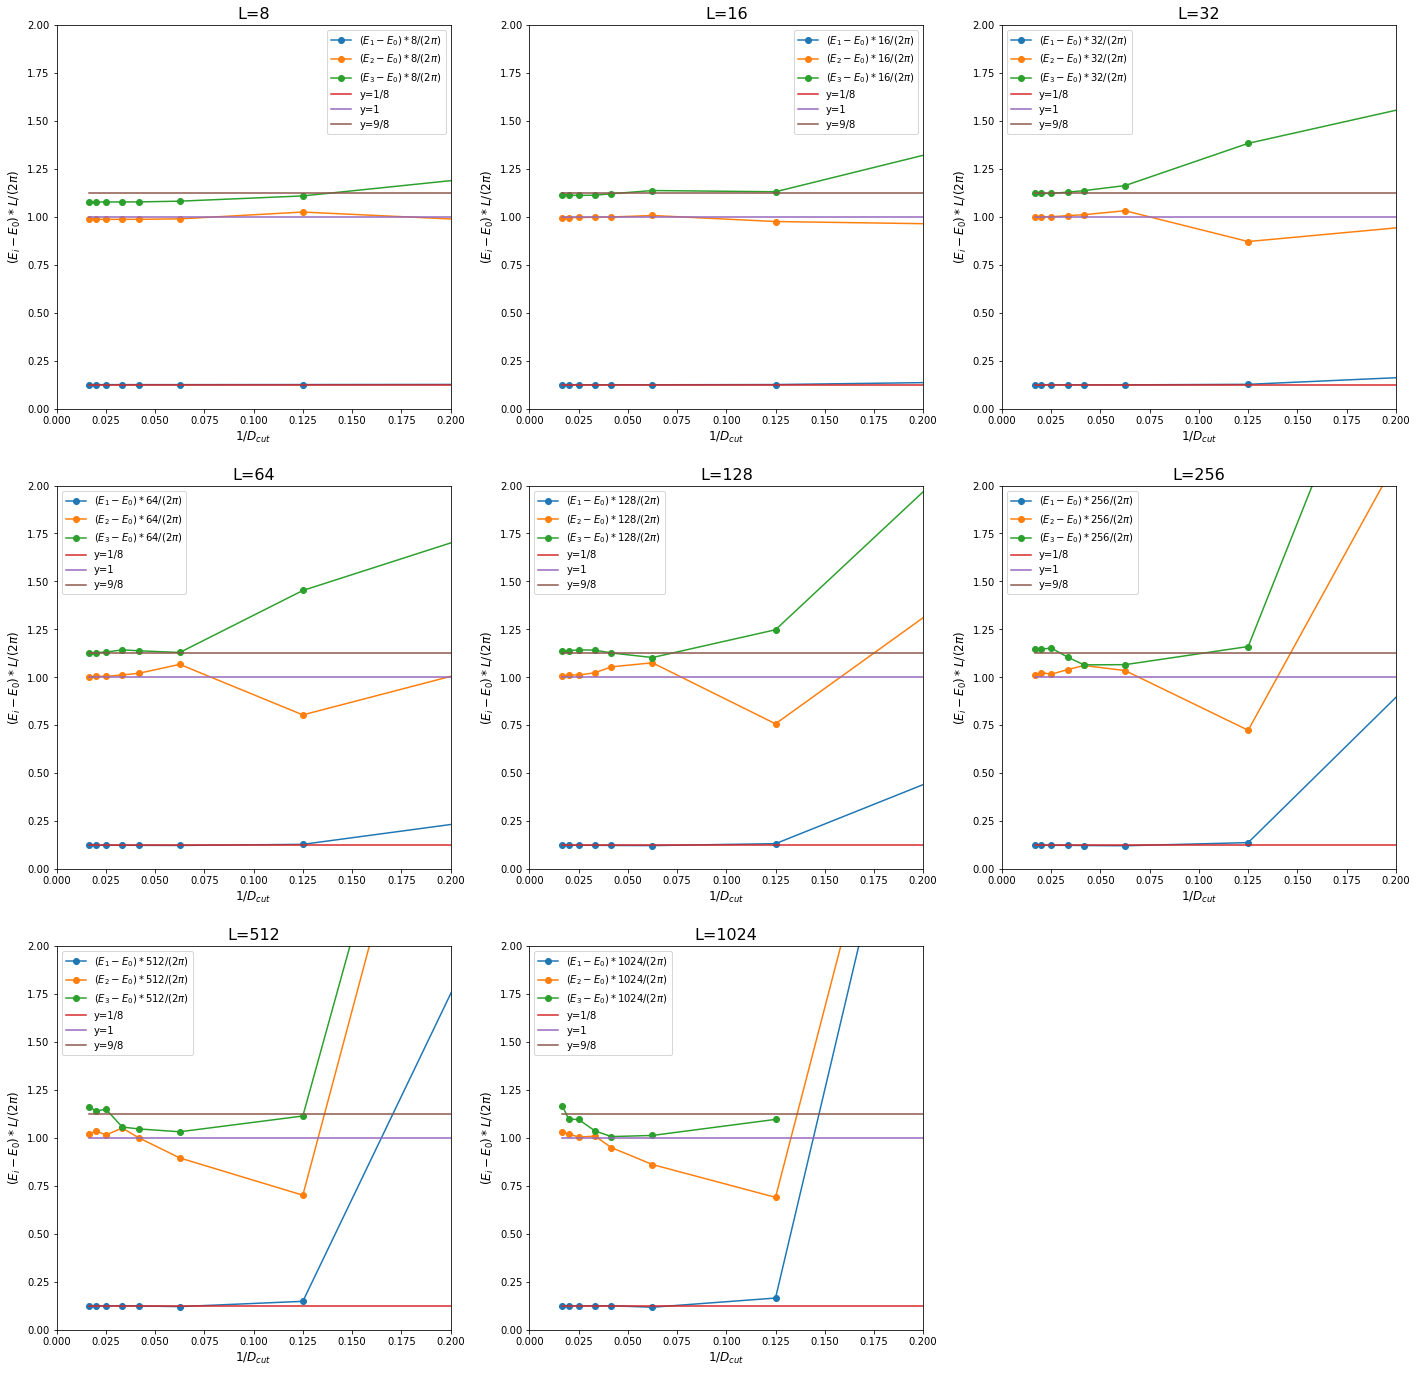

In [7]:
select_indexs = [i for i in range(1,4)] # skip E0
FILE = "./group_by_L"
Ls  = [2**(i) for i in range(3,11)]
Ls  = list(map(str,Ls))
bds = [4,8,16,24,30,40,50,60]
one_over_bds = list(map(lambda x: 1/x,bds))
bds = list(map(str,bds))
plt.figure(figsize=(24,24))
k = 1
for L in Ls:
    plt.subplot(3,3,k)
    k += 1
    DF = pd.read_csv(r"./group_by_L"+"/ln_lambda_prime_L_{}.csv".format(L))
    E0minuxEi = np.zeros((len(bds),len(select_indexs)))
    for i, bd in enumerate(bds):
        indexs = len(select_indexs)
        E0 = DF['Ei_bd_{}'.format(bd)][0]
        for j,idx in enumerate(select_indexs):
            E0minuxEi[i][j] = (E0-DF['Ei_bd_{}'.format(bd)][idx])*int(L) / (2*np.pi)
    for i in range(len(select_indexs)):
        plt.plot(one_over_bds,E0minuxEi[:,i],"o-",label="$(E_{}-E_0)*{}/(2\pi)$".format(select_indexs[i],L))
    plt.plot(one_over_bds,[0.125 for i in range(len(one_over_bds))],label='y=1/8')
    plt.plot(one_over_bds,[1 for i in range(len(one_over_bds))],label='y=1')
    plt.plot(one_over_bds,[1.125 for i in range(len(one_over_bds))],label='y=9/8')
    plt.legend(loc='best')
    plt.title('L={}'.format(L),fontsize=16)
    plt.ylabel('$(E_i-E_0)*L/(2\pi)$',fontsize=12)
    plt.xlabel('$1/D_{cut}$',fontsize=12)
    plt.ylim((0,2))
    plt.xlim((0,0.2))
plt.savefig(r"./group_by_L/"+"energy_diff.pdf".format(L))

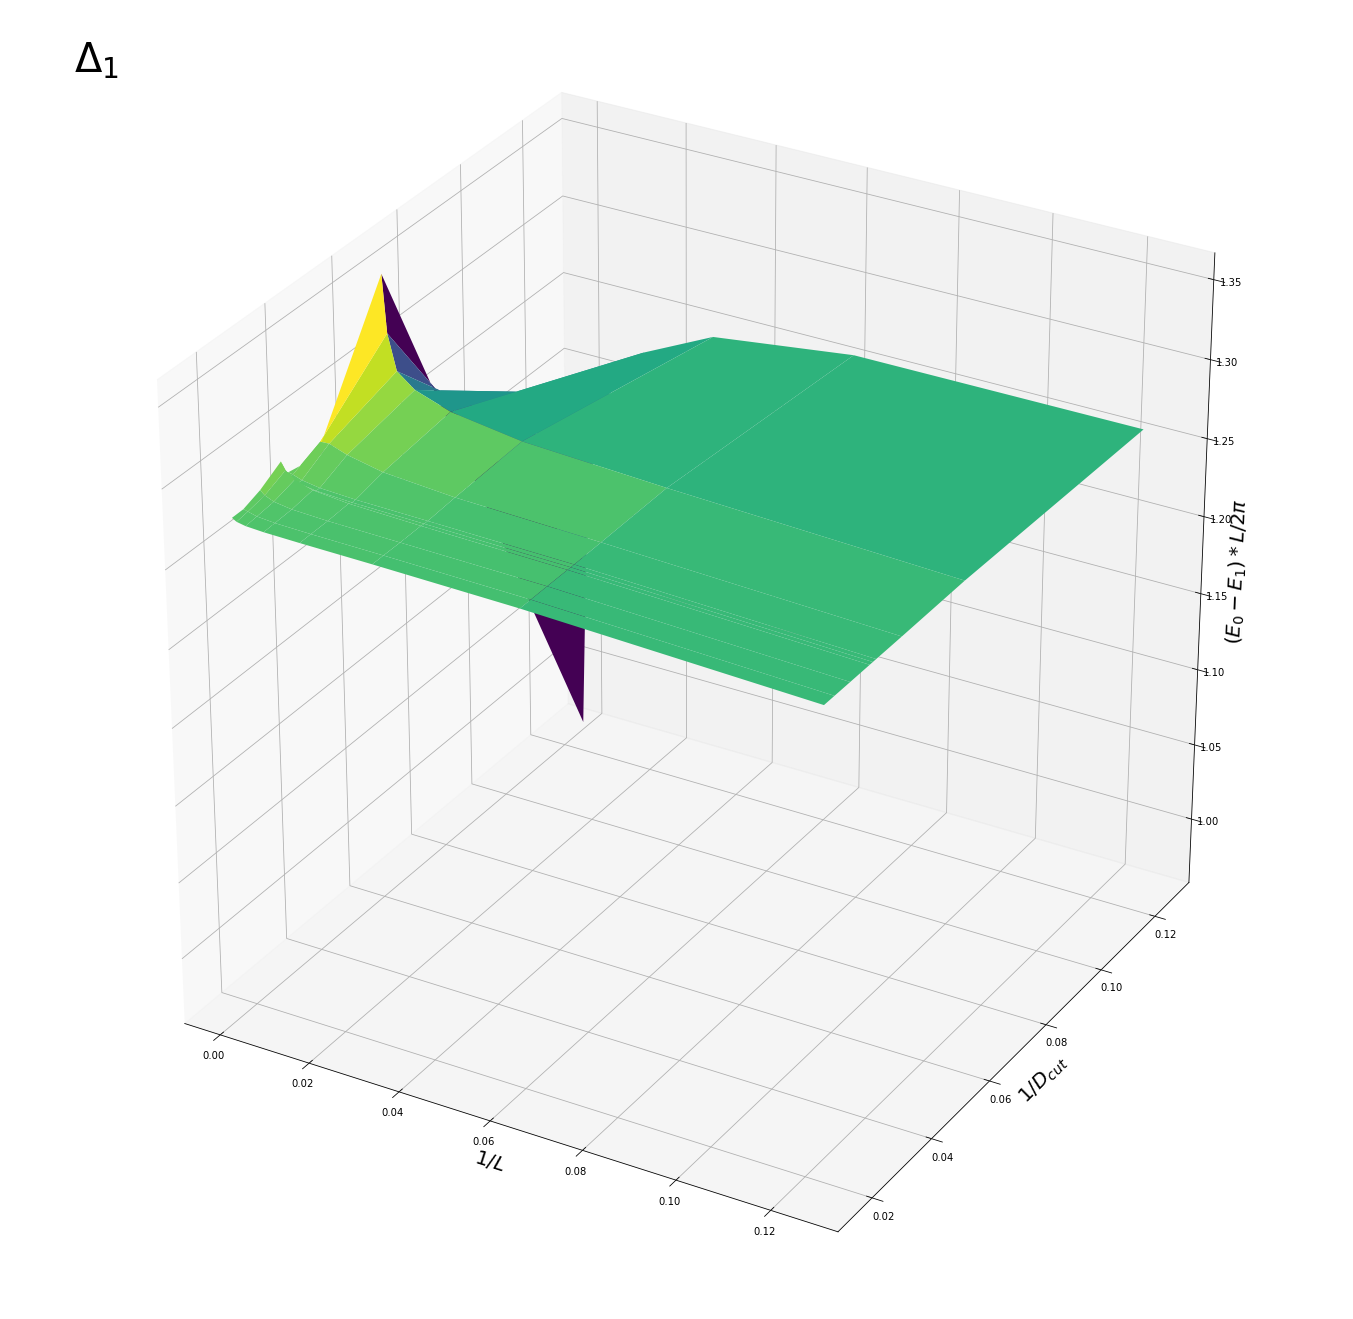

<Figure size 1728x1728 with 0 Axes>

<Figure size 1728x1728 with 0 Axes>

<Figure size 1728x1728 with 0 Axes>

<Figure size 1728x1728 with 0 Axes>

<Figure size 1728x1728 with 0 Axes>

<Figure size 1728x1728 with 0 Axes>

<Figure size 1728x1728 with 0 Axes>

<Figure size 1728x1728 with 0 Axes>

In [13]:
def makeFolder(Filename,sep='/'):
    '''file name may contains several folders, so need to check
    individually'''
    subFolderPath = Filename.split('/')
    complete = '.'
    for subFolderP in subFolderPath:
        complete = "/".join([complete,subFolderP])
        dir_path = Path(complete)
        if not dir_path.exists():
            dir_path.mkdir()
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

select_indexs = [i for i in range(1,2)] # skip E0
FILE = "./group_by_L"
FILE2 = "./group_by_Ei"
makeFolder(FILE2)

Ls  = [2**(i) for i in range(3,11)]
bds = [8,16,24,30,32,40,50,60]
LsGrid = 1/np.array(Ls)
BdsGrid = 1/np.array(bds)
LsGrid,BdsGrid = np.meshgrid(LsGrid,BdsGrid)
one_over_bds = list(map(lambda x: 1/x,bds))
bds = list(map(str,bds))
Ls  = list(map(str,Ls))


for k,idx in enumerate(select_indexs,1):
    fig = plt.figure(figsize=(24,24))
    E0minuxEi = np.zeros((len(bds),len(Ls)))
    for i,L in enumerate(Ls):
        plt.figure(figsize=(24,24))
        DF = pd.read_csv(r"./group_by_L"+"/ln_lambda_prime_L_{}.csv".format(L))
        for j, bd in enumerate(bds):
            E0 = DF['Ei_bd_{}'.format(bd)][0]
            E0minuxEi[j][i] = 1/(E0-DF['Ei_bd_{}'.format(bd)][idx])/int(L)#*int(L) #/ (2*np.pi)
        
    ax = fig.gca(projection='3d')
    ax.plot_surface(LsGrid,BdsGrid,E0minuxEi,rstride=1, cstride=1,cmap='viridis', edgecolor='none')
    ax.text2D(0.05, 0.95, r"$\Delta_{}$".format(idx), transform=ax.transAxes,fontsize=40)
    ax.set_xlabel('$1/L$',fontsize=20)
    
    ax.set_ylabel('$1/D_{cut}$',fontsize=20)
    ax.set_zlabel(r"$(E_0 - E_{})*L/2\pi$".format(idx),fontsize=20)
    fig.savefig('E0minusE{}.pdf'.format(idx))
#     for i in range(len(select_indexs)):
#         plt.plot(one_over_bds,E0minuxEi[:,i],"o-",label="$(E_{}-E_0)*{}/(2\pi)$".format(select_indexs[i],L))
#     plt.plot(one_over_bds,[0.125 for i in range(len(one_over_bds))],label='y=1/8')
#     plt.plot(one_over_bds,[1 for i in range(len(one_over_bds))],label='y=1')
#     plt.plot(one_over_bds,[1.125 for i in range(len(one_over_bds))],label='y=9/8')
#     plt.legend(loc='best')
#     plt.zlabel('$(E_i-E_0)*L/(2\pi)$',fontsize=12)
#     ax.sexlabel('$1/D_{cut}$',fontsize=12)
#     plt.ylabel('$1/L$',fontsize=12)
#     plt.ylim((0,1.2))
#     plt.savefig(r"./group_by_L/"+"energy_diff_L{}.pdf".format(L))

In [3]:
print(np.pi/2/6)

0.2617993877991494
